In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path
import pandas as pd

In [2]:
import firecurve as fc
import running as rn
import makefiles as mf
import thermalrestart as tr
from Analytical_solution_Dirichlet import analytical_dirichlet
import Post_Processor as pp
import ADDflux as af

655.86

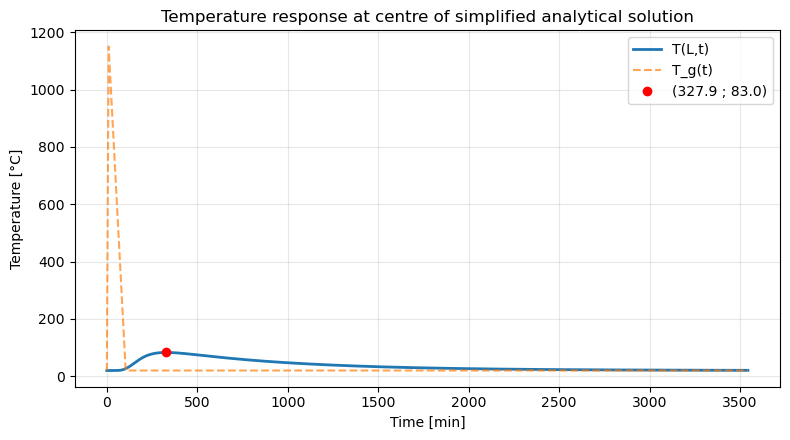

In [3]:
# ---------------- Material Inputs ----------------
e0 = 0.02            # Imperfection [m]
rho = 420            # Density (Including moisture) [kg/m^3]
mu = 0.3             # Poisson ratio [-]
w = 12               # Moisture content


# E = 12.8e9             # Modulus of Elasticity [Pa]
# f_c = 40.4e6            # Compressive strentgh [Pa]
# f_t = 26.4e6            # Tensile strength [Pa]

E = 11.5e9 #            # Modulus of Elasticity [Pa]
f_c = 24e6               # Compressive strentgh [Pa]
f_t = 19.2e6            # Tensile strength [Pa]


h_ch = 35            # Conection coefficient heating []
h_cc = 4             # Convection coefficient cooling []
eps = 0.8            # Relative emissivity [-]
struc_material_name = 'WOODPRBWE'
struc_material_params = (E, mu, f_c, f_t, 0.5, 0)
# struc_material_name = 'WOODEC5'
# struc_material_params = (E, mu, f_c, f_t, 0)
# ---------------------------------------------
# ---------------- Structural Inputs ----------
B = 0.34          # Column width [m]
l = 3.65          # Column length [m]
F = 322000        # Applied force [N]
# ---------------------------------------------
# ---------------- Fire Inputs ----------------
T0     = 20.0     # ambient [°C]
t_h    = 10.0     # heating duration to peak [min]
# T_max  = round(T0 + 1325 * fc.phi(t_h/60), 2)   # peak gas temperature at t = t_h [°C] (<=1325). Tau is equal to 1. (ISO heating)
T_max  = 1150   # peak gas temperature at t = t_h [°C] (<=1325).
r_cool = 12      # linear cooling rate [°C/min]; set None to skip cooling
t_end  = round(analytical_dirichlet(B, rho, T_max, t_h, r_cool, c=1700)[0]*2, 2)   # end time of the curve [min] (>= t_h), analytically determined with dirichlet boundary condition of T_g(t) times two.
dt     = 0.5      # time step [min]
# ---------------------------------------------
# ---------------- Numerical Inputs ----------------
fine_size = 0.0025    # Mesh size of Thermal analysis
# n_elements = 21    # Mesh size of Structural analysis
n_elements, mesh_size = mf.compute_mesh_and_nelements(l, 0.25) # Determination of the beam element mesh size for the structural analysis
# ---------------------------------------------
t_end

In [4]:
q_dist = B*B*rho*10
M0 = e0 * F
t_end_guess = t_end

In [5]:
workdir =      # local computer working directory
name_firecurve = f'fr_218.fct'
name_thermalfile = f'thermo_218.IN'
name_mechfile = f'COLUMN_218.IN'

Exact area above ambient up to t_end: 285666.75 °C·min  (4761.11 °C·h)
File saved at: C:\Users\justu\OneDrive - Delft University of Technology\Documents\Master Thesis\SAFIR\Files\TESTS\TEST_218\fr_218.fct


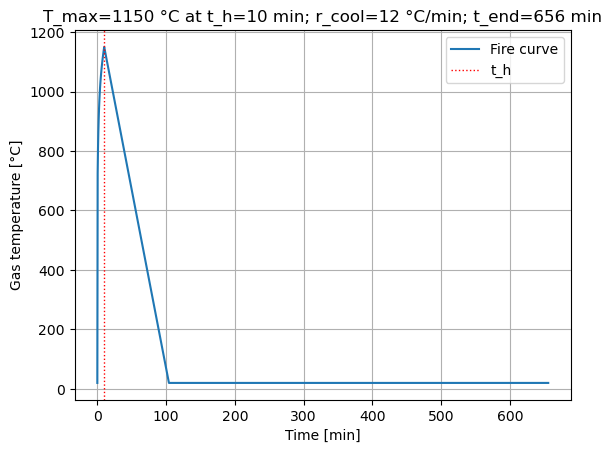

In [6]:
# Firecurve
t_all, T_all, tau = fc.build_fire_curve(T0=T0, T_max=T_max, t_h=t_h, r_cool=r_cool, t_end=t_end, dt=dt, plot_curve=True)
# H = fc.area_firecurve(T0, T_max, t_h, r_cool, t_end, tau)
# print(f"Exact area above ambient up to t_end: {H:.2f} °C·min  ({H/60:.2f} °C·h)")
outfile = fc.save_fct(t_all, T_all, filename=name_firecurve, out_dir=workdir)

In [7]:
tau = 23.72
T_start = 100
T_end = 120
therm_material_name = 'USER1'  # Use HOPKINS thermal model, with Cachim and Franssen
therm_material_params = (rho, w, T_start, T_end, h_ch, h_cc, eps, 1, tau)   # Material irreversibility +1 / Material reversibility -1
# therm_material_name = 'WOODEC5'
# therm_material_params = (rho, w, h_ch, h_cc, eps, 4, 0, 0, 1)

File saved at: C:\Users\justu\OneDrive - Delft University of Technology\Documents\Master Thesis\SAFIR\Files\TESTS\TEST_218\fr_218.fct
23.72


384.4166666666667

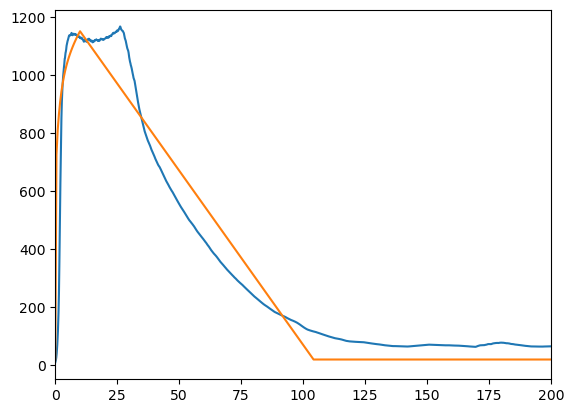

In [8]:
data = np.loadtxt('Natural_fire_test_data/TEST12/TF_12.fct')
times = data[:, 0]/60
Temps = data[:, 1]
plt.plot(times, Temps)
plt.plot(t_all, T_all)
plt.xlim(0, 200)

outfile = fc.save_fct(times, Temps, filename=name_firecurve, out_dir=workdir)
print(tau)
t_end = times[-1]
t_end

In [9]:
depth, rates = af.char_depth_cumulative_temp(times*60, Temps)
flux = af.make_flux_curve(rates, 18.3e6, 375, eff=0.035)
mesh_times, mesh_positions = af.interp_time(fine_size, B, times*60, depth/1000)
outfiles = af.save_flux_segments(times, flux, mesh_times, out_dir=workdir)
# outfile = af.save_flux(times, flux, out_dir=workdir) # This is for only additional flux at the outside boundaries

In [10]:
# Thermal Analysis
nfiber = mf.make_cross_section_SYM(workdir=workdir, filename=name_thermalfile, B=B, fine_size=fine_size, frontier_name=name_firecurve, T_initial=20.0, comeback=0.001, precision=1e-3, dt0=7.5, t_final=t_end*60, dtmax=30.0, timeprint=60.0, material_name=therm_material_name, material_params=therm_material_params, add_flux=True, mesh_positions=mesh_positions)

File saved at: C:\Users\justu\OneDrive - Delft University of Technology\Documents\Master Thesis\SAFIR\Files\TESTS\TEST_218\thermo_218.IN


In [ ]:
inp = Path(workdir) / Path(name_thermalfile).stem
rn.run_safir(input_file=inp, env_var="SAFIREXE", workdir=workdir)

# Restart method is not valid for the additional heat source term 
# restart = tr.thermal_restart(workdir, name_thermalfile, B, fine_size)
# for r in range(1, 15):
#     if restart['runs'] > 1:
#         t_end = restart['last_time']/60
#         workdir = Path(workdir) / f'Batch0{r}'
#         t_all, T_all, tau = fc.build_fire_curve(T0=T0, T_max=T_max, t_h=t_h, r_cool=r_cool, t_end=t_end, dt=dt, plot_curve=False)
#         H = fc.area_firecurve(T0, T_max, t_h, r_cool, t_end, tau)
#         outfile = fc.save_fct(t_all, T_all, filename=name_firecurve, out_dir=workdir)
#         nfiber = mf.make_cross_section_SYM(workdir=workdir, filename=name_thermalfile, B=B, fine_size=fine_size, frontier_name=name_firecurve, T_initial=20.0, comeback=0.01, precision=1e-3, dt0=7.5, t_final=t_end*60, dtmax=30.0, timeprint=60.0, material_name=therm_material_name, material_params=therm_material_params)
#         inp = Path(workdir) / Path(name_thermalfile).stem
#         rn.run_safir(input_file=inp, env_var="SAFIREXE", workdir=workdir)
#         restart = tr.thermal_restart(workdir, name_thermalfile, B, fine_size)
#     else:
#         break

In [ ]:
nodes = [] 
names_tcs = ['10 mm', '20 mm', '30 mm', '40 mm', '50 mm', '60 mm', '70 mm', '80 mm']
thermo_couples = pp.get_temperatures(workdir, f'{Path(name_thermalfile).stem}.OUT', nodes, column_names=names_tcs)

In [11]:
# Structural Analysis
tem_file = f"{Path(name_thermalfile).stem}.TEM"
mf.make_column(workdir=workdir, filename=name_mechfile, length=l, tem_file=tem_file, nfiber=nfiber, elements=n_elements, ng=3 ,comeback=1e-09,  F_function='FLOAD', nodeload1=(0.0, 0.0, -M0), nodeload2=(0.0, -F, M0), q_dist=-q_dist, t_final=t_end*60, timeprint=60.0 ,material_name=struc_material_name, material_params=struc_material_params, stresses=True)
inp_2 = Path(workdir) / Path(name_mechfile).stem
rn.run_safir(input_file=inp_2, env_var="SAFIREXE", workdir=workdir)

File saved at: C:\Users\justu\OneDrive - Delft University of Technology\Documents\Master Thesis\SAFIR\Files\TESTS\TEST_218\COLUMN_218.IN
---- SAFIR STDOUT ----
  SAFIR is allocating memory
  SAFIR has finished subroutine DONNEE
  BEGINNING OF PARDISO ALLOCATION
   Beginning of TSKY
   End of TSKY
   Beginning of TLINK
   End of TLINK


 SIZE OF THE MODEL

 Length of the vector that contains the matrix : 
  END OF PARDISO ALLOCATION
 Reordering of the matrix completed by PARDISO 
 Number of nonzeros in factors =          417
 Number of factorization MFLOPS =            0

 time =      1.00000 sec.

 time =      2.00000 sec.

 time =      3.00000 sec.

 time =      5.00000 sec.

 time =      7.00000 sec.

 time =      9.00000 sec.

 time =     13.00000 sec.

 time =     17.00000 sec.

 time =     21.00000 sec.

 time =     29.00000 sec.

 time =     37.00000 sec.

 time =     45.00000 sec.

 time =     61.00000 sec.
 ITER = 2

 time =     77.00000 sec.

 time =     93.00000 sec.

 time =

In [12]:
failure_time, failure = pp.postprocess_failure(workdir, f'{Path(name_mechfile).stem}.OUT', t_end)
time_thermo = pp.get_simulation_time(workdir, f'{Path(name_thermalfile).stem}.OUT')
time_mech = pp.get_simulation_time(workdir, f'{Path(name_mechfile).stem}.OUT')
time_tot = pp.sum_times([time_thermo, time_mech])
pp.make_description(workdir, 'AA_Description.txt', time_thermo, time_mech, time_tot, e0, rho, E, mu, f_c, f_t, w, h_ch, h_cc, eps, B, l, F, T0, t_h, T_max, r_cool, t_end, dt, fine_size, n_elements, failure, failure_time)
# nodes = [209, 417, 625, 833, 1041, 1249, 1457, 1665]
# thermo_couples = pp.get_temperatures(workdir, f'{Path(name_thermalfile).stem}.OUT', nodes)

In [13]:
stiffness = pp.get_stiffness(workdir, f'{Path(name_mechfile).stem}.OUT', n_elements=n_elements)

In [16]:
failure_time

384.42

In [17]:
failure

False